# **Procedure Vs. Gender Analytics | Partner Focus Question 1 Notebook**

#### **Purpose:**
The purpose of this notebook is to explore and address our project partner’s focus question 1, what, if any,  relationship exists between EMS **procedures** performed on a patient given by a provider based on the **gender** of either. This notebook prepares the data and defines the analytics for procedures performed compared to the genders of both patient and provider.
<br>
The dataset used to build the analytics is the intermediate Procedures+Patients merged dataset that was conditioned in a prior data engineering step. The script that creates this dataset also drops duplicates and removes some NULL records.

#### **Exit Criterion:** 
1. Script(s) developed that perform any required data conditioning to answer this specific focus question but would not have been necessary for all focus questions (e.g., throwing out bad values, taking unique values, grouping data, etc.).

2. Script(s) have been tested by another team member, and after successful testing the script(s) have been merged into Main on GitHub.

3. After successful testing, processed dataset has been exported to s3/data/03_processed for use by other team members.

4. Plan for what analytics we will run for this focus question as well as required data preparation/assumptions have been documented in Report Section 3.x and peer reviewed.

5. If additional work needs to be done to create and run analytics, user story for that work is created.

*Author: Mark Lee*


## **Dataset**
### **Assumptions**

This script reads in the joined Patients and Medications dataset from the data/02_intermediate folder. Each row represents a single instance of a medication given to a patient. If a single patient is given one medication multiple times, that would be reflected as multiple rows in this dataset.

FRDPersonnelID 9E5D40DC-5DC6-E411-80C7-001DD8B71D38 had many duplicate records in the raw Medications dataset that could be removed per our FCFRD partners. These duplicates were removed prior to the joining process.

Rows in the raw Patients dataset with null Provider Gender or Provider Start Date were dropped prior to the joining process. Rows with null Patient Gender were retained for the other focus question using this dataset. Null Patient Gender rows will need to be removed prior to this analysis.


### **Functions and Imports**

#### Function to identify and print easy to understand variable types

In [1]:
def get_var_category(series):
    unique_count = series.nunique(dropna=False)
    total_count = len(series)
    if pd.api.types.is_numeric_dtype(series):
        return 'Numerical'
    elif pd.api.types.is_datetime64_dtype(series):
        return 'Date'
    elif unique_count == total_count:
        return 'Text (Unique)'
    else:
        return 'Categorical'

def print_categories(df):
    for column_name in df.columns:
        print(column_name, ": ", get_var_category(df[column_name]))

#### **Import Python libraries**

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import os, time
import copy

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

# Setup HTML display
from IPython.core.display import display, HTML
# Notebook cell width adjustment
display(HTML('<style>.container { width:80% !important; }</style>'))

#### **Read in intermediate Procedures+Patients merged dataset**

In [3]:
# Parse date columns so Pandas recognizes them as date fields
dfProcPat = pd.read_csv(r'./data/ProceduresPatients-Intermediate.csv', parse_dates=['FRDPersonnelStartDate','DispatchTime'])
dfProcPat.shape

(170072, 18)

#### **Read in Procedure category groups**

Read in derived dataset based on procedure groupings provided by partner team. This procedure grouping will ultimately reduce the number of procedure from 67 to 31 and will help make the analysis and visualizations more concise.

In [4]:
dfProcGrp = pd.read_csv(r'./data/ProcedureGroups.csv')
dfProcGrp.shape

(68, 4)

### **Exploring the datasets**

Check column data types using print_categories() function for both the Procedures+Patients and the Procedure category groups dataset

In [5]:
print_categories(dfProcPat)

PatientId :  Numerical
FRDPersonnelID :  Categorical
PatientOutcome :  Categorical
PatientGender :  Categorical
DispatchTime :  Date
FRDPersonnelGender :  Categorical
FRDPersonnelStartDate :  Date
Dim_Procedure_PK :  Numerical
Procedure_Performed_Code :  Numerical
Procedure_Performed_Description :  Categorical
_PK :  Categorical
TenureMonths :  Numerical
PatientOutcomeCode :  Numerical
PatientGenderCode :  Numerical
PatientGender_Female :  Numerical
PatientGender_Male :  Numerical
PatientGender_Unknown (Unable to Determine) :  Numerical
ProviderGenderCode :  Numerical


In [6]:
print_categories(dfProcGrp)

Procedure_Performed_Description :  Text (Unique)
Procedure_Performed_Code :  Numerical
CategoryLabel :  Categorical
CategoryCode :  Numerical


#### **Missing values**

Check for full NULL count

In [7]:
dfProcPat.isnull().values.sum()

104

List NULL count by column

In [8]:
dfProcPat.isnull().sum()

PatientId                                        0
FRDPersonnelID                                   0
PatientOutcome                                   0
PatientGender                                  104
DispatchTime                                     0
FRDPersonnelGender                               0
FRDPersonnelStartDate                            0
Dim_Procedure_PK                                 0
Procedure_Performed_Code                         0
Procedure_Performed_Description                  0
_PK                                              0
TenureMonths                                     0
PatientOutcomeCode                               0
PatientGenderCode                                0
PatientGender_Female                             0
PatientGender_Male                               0
PatientGender_Unknown (Unable to Determine)      0
ProviderGenderCode                               0
dtype: int64

There are 104 NULL values for Patient Gender

In [9]:
dfProcGrp.isnull().values.sum()

0

There are no NULL values for procedure category groups

#### **Unique values**

List of unique values and row count by select categorical columns

In [10]:
print('Patient Outcome Unique Value Count: ', dfProcPat['PatientOutcome'].value_counts().count())
print('Patient Gender Unique Value Count: ', dfProcPat['PatientGender'].value_counts().count())
print('Provider Gender Unique Value Count: ', dfProcPat['FRDPersonnelGender'].value_counts().count())
print('Procedure Performed Desc Unique Value Count: ', dfProcPat['Procedure_Performed_Description'].value_counts().count())
print('Procedure Performed Code Unique Value Count: ', dfProcPat['Procedure_Performed_Code'].value_counts().count())

Patient Outcome Unique Value Count:  9
Patient Gender Unique Value Count:  3
Provider Gender Unique Value Count:  2
Procedure Performed Desc Unique Value Count:  68
Procedure Performed Code Unique Value Count:  67


Looks like there are a couple of issue here: 
- Patient Gender has a 3 count of values
- Procedure Performed Description and Code have values of 68 and 67

This issue with Procedure Performed Description is the source data has the same code for both descriptions of "Airway - Supraglottic Airway (King, i-Gel)" and  "Airway - Supraglottic Airway (i-Gel, King)". So, a replacement will be made.

#### **Replace Procedure Description**

In [11]:
dfProcPat['Procedure_Performed_Description'] = dfProcPat['Procedure_Performed_Description'] \
                                               .replace(['Airway - Supraglottic Airway (King, i-Gel)'],
                                                        'Airway - Supraglottic Airway (i-Gel, King)')

Checking the 3 types of Patient Gender
<br><br>
List of Patient Gender unique values and row counts

In [12]:
dfProcPat['PatientGender'].value_counts()

Male                             89956
Female                           79942
Unknown (Unable to Determine)       70
Name: PatientGender, dtype: int64

Analysis will require the Patient Gender be known, so need to remove:
- "Unknown (Unable to Determine)" 70 row count (0.04% of the data)
- NULL values 104 row count or (0.06% of the data)

#### **Remove all Patient Gender NULL and Unknown rows**

In [13]:
dfProcPat = dfProcPat.drop(dfProcPat[(dfProcPat.PatientGender.isnull())].index)
dfProcPat.shape

(169968, 18)

In [14]:
dfProcPat = dfProcPat[dfProcPat.PatientGender != 'Unknown (Unable to Determine)']
dfProcPat.shape

(169898, 18)

#### **Analysis for Data Imbalances for Gender Attributes**

With an imbalance in the data some of the analysis and visualizations distributions will become skewed

|Individual Id Counts||||||Row Counts||||||
|--||--||--||--||||||
|Patient Gender|||||||
|Female||45,605||49.6%||Female||79,942||47.1%|
|Male||46,421||50.4%||Male||89,956||52.9%|
|Total||92,026||100.0%||Total||169,898||100.0%|
|Provider Gender|||||||
|Female||215||17.1%||Female||29,803||17.5%|
|Male||1,045||82.9%||Male||140,095||82.5%|
|Total||1,260||100.0%||Total||169,898||100.0%|

#### **Create horizontal bar chart of Patient Gender by percentage of individual identifier (ID) count**

In [15]:
patGendCntInv = len(pd.unique(dfProcPat['PatientId']))
dfPatGendInv = dfProcPat.groupby(['PatientId','PatientGender']).count()
dfPatGendInv = dfPatGendInv.groupby(['PatientGender']).size().astype(float).reset_index(name='Count')
dfPatGendInv = dfPatGendInv.assign(Pct = lambda x: (x['Count'] /patGendCntInv * 100))
dfPatGendInv

,PatientGender,Count,Pct
0,Female,45605.0,49.556647
1,Male,46421.0,50.443353


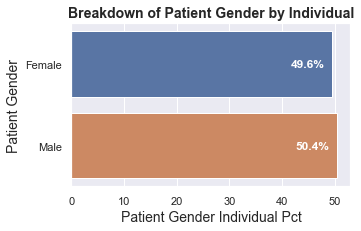

In [16]:
sns.set_theme()
fig, ax = plt.subplots(figsize = (5,3))
ax = sns.barplot(y='PatientGender',
                 x='Pct',
                 data=dfPatGendInv)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    ax.text(x = width-8,
            y = p.get_y() + (height/2),
            s = "%.1f%%"% p.get_width(),
            color='white',
            fontweight='bold',
            va = 'center') 
ax.set_title('Breakdown of Patient Gender by Individual',
              fontdict={'fontsize': 14,
                        'fontweight':'bold'})
ax.set_xlabel('Patient Gender Individual Pct',fontsize=14)
ax.set_ylabel('Patient Gender',fontsize=14)
plt.show()

#### **Create horizontal bar chart of Patient Gender by percentage of row count**

In [17]:
genderCntTotal = dfProcPat['PatientGender'].count().astype(float)
dfPatGendRow = dfProcPat.groupby(['PatientGender']).size().astype(float).reset_index(name='Count')
dfPatGendRow = dfPatGendRow.assign(Pct = lambda x: (x['Count'] /genderCntTotal * 100))
dfPatGendRow

,PatientGender,Count,Pct
0,Female,79942.0,47.052938
1,Male,89956.0,52.947062


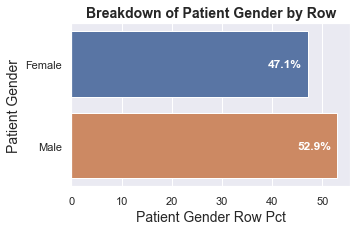

In [18]:
fig, ax = plt.subplots(figsize = (5,3))
ax = sns.barplot(y='PatientGender',
                 x='Pct',
                 data=dfPatGendRow)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    ax.text(x = width-8,
            y = p.get_y() + (height/2),
            s = "%.1f%%"% p.get_width(),
            color='white',
            fontweight='bold',
            va = 'center') 
ax.set_title('Breakdown of Patient Gender by Row',
              fontdict={'fontsize': 14,
                        'fontweight':'bold'})
ax.set_xlabel('Patient Gender Row Pct',fontsize=14)
ax.set_ylabel('Patient Gender',fontsize=14)
plt.show()

add note on any imbalance

#### **Create horizontal bar chart of Provider Gender by percentage of individual identifier (ID) count**

In [19]:
provGendCntInv = len(pd.unique(dfProcPat['FRDPersonnelID']))
dfProvGendInv = dfProcPat.groupby(['FRDPersonnelID','FRDPersonnelGender']).count()
dfProvGendInv = dfProvGendInv.groupby(['FRDPersonnelGender']).size().astype(float).reset_index(name='Count')
dfProvGendInv = dfProvGendInv.assign(Pct = lambda x: (x['Count'] /provGendCntInv * 100))
dfProvGendInv

,FRDPersonnelGender,Count,Pct
0,Female,215.0,17.063492
1,Male,1045.0,82.936508


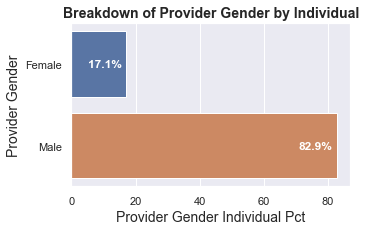

In [20]:
fig, ax = plt.subplots(figsize = (5,3))
ax = sns.barplot(y='FRDPersonnelGender',
                 x='Pct',
                 data=dfProvGendInv)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    ax.text(x = width-12,
            y = p.get_y() + (height/2),
            s = "%.1f%%"% p.get_width(),
            color='white',
            fontweight='bold',
            va = 'center') 
ax.set_title('Breakdown of Provider Gender by Individual',
              fontdict={'fontsize': 14,
                        'fontweight':'bold'})
ax.set_xlabel('Provider Gender Individual Pct',fontsize=14)
ax.set_ylabel('Provider Gender',fontsize=14)
plt.show()

#### **Create horizontal bar chart of Provider Gender by percentage of row count**

In [21]:
# Use the already create genderCntTotal variable
dfProvGendRow = dfProcPat.groupby(['FRDPersonnelGender']).size().astype(float).reset_index(name='Count')
dfProvGendRow = dfProvGendRow.assign(Pct = lambda x: (x['Count'] /genderCntTotal * 100))
dfProvGendRow

,FRDPersonnelGender,Count,Pct
0,Female,29803.0,17.541701
1,Male,140095.0,82.458299


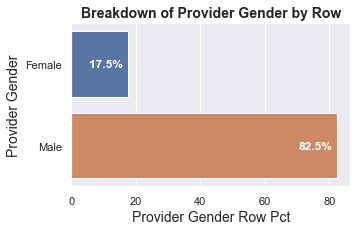

In [22]:
fig, ax = plt.subplots(figsize = (5,3))
ax = sns.barplot(y='FRDPersonnelGender',
                 x='Pct',
                 data=dfProvGendRow)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    ax.text(x = width-12,
            y = p.get_y() + (height/2),
            s = "%.1f%%"% p.get_width(),
            color='white',
            fontweight='bold',
            va = 'center') 
ax.set_title('Breakdown of Provider Gender by Row',
              fontdict={'fontsize': 14,
                        'fontweight':'bold'})
ax.set_xlabel('Provider Gender Row Pct',fontsize=14)
ax.set_ylabel('Provider Gender',fontsize=14)
plt.show()

### **Merge datasets**

#### **Merge Procedures+Patients dataframe with Procedure Groupings dataframe**

In [23]:
dfProcPat = dfProcGrp.merge(dfProcPat, 
                        on=('Procedure_Performed_Description','Procedure_Performed_Code'))
dfProcPat.shape

(169898, 20)

Add a new column that will act as the display for the y-axis summary text and for name of the chart legend.

In [24]:
dfProcPat['ProviderPatientGender'] = 'Provider: ' + dfProcPat['FRDPersonnelGender'] + ' | ' + 'Patient: ' + dfProcPat['PatientGender']

#### **Countplot of procedures categories performed distribution**

Looking for data skewness based on high counts of procedures performed

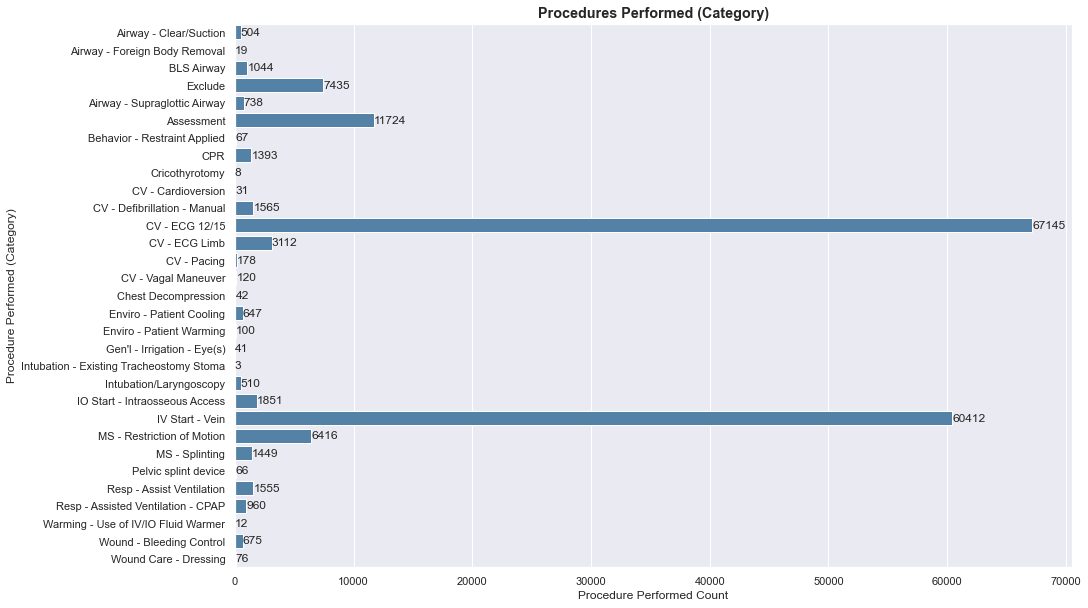

In [25]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.countplot(y='CategoryLabel',
                   color='steelblue',
                   data=dfProcPat)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    ax.text(x = width+1,
            y = p.get_y() + (height/2),
            s = p.get_width(),
            va = 'center') 
ax.set(xlabel='Procedure Performed Count', ylabel='Procedure Performed (Category)')
ax.set_title('Procedures Performed (Category)', fontsize='large', fontweight = 'bold')
plt.show()

The category procedures "CV - EG - 12/15" and "IV Start - Vein" are clearly the majority of the procedures

## **Analysis for Procedures Performed Category**

### **Define new dataframes for Provider gender**

In [26]:
dfProviderF = dfProcPat[(dfProcPat.FRDPersonnelGender == 'Female')]
dfProviderM = dfProcPat[(dfProcPat.FRDPersonnelGender == 'Male')]

Reduce dataframe size to only columns necessary for analytics.

Follow up with using a group by and an aggregate function to roll up and count each row for each procedure performed by a female provider to a patient of each gender and then the same thing for male providers.

Then for later analytics, create the percentage of procedures given to patients for female and male providers separately. This will help balance the provider gender data since there are roughly five times as many male providers than there are female providers.

In [27]:
dfcols = ['FRDPersonnelGender','CategoryLabel','PatientGender','ProviderPatientGender','_PK']
dfProviderF[dfcols]
dfProviderM[dfcols]

dfProviderF = dfProviderF.groupby(['FRDPersonnelGender','CategoryLabel',
                                   'PatientGender','ProviderPatientGender']).agg({'_PK' : 'count'}).reset_index()
dfProviderM = dfProviderM.groupby(['FRDPersonnelGender','CategoryLabel',
                                   'PatientGender','ProviderPatientGender']).agg({'_PK' : 'count'}).reset_index()

dfProviderF.rename(columns = {'_PK':'ProcedurePct', 'FRDPersonnelGender':'ProviderGender'}, inplace = True)
dfProviderM.rename(columns = {'_PK':'ProcedurePct', 'FRDPersonnelGender':'ProviderGender'}, inplace = True)

dfProviderFPct = dfProviderF.groupby(['ProviderGender','CategoryLabel',
                                      'PatientGender','ProviderPatientGender'])["ProcedurePct"].sum()
dfProviderFPct = (dfProviderFPct / dfProviderFPct.groupby(level=[0]).transform("sum")) * 100

dfProviderF = dfProviderFPct.reset_index()
print(type(dfProviderF))

dfProviderMPct = dfProviderM.groupby(['ProviderGender','CategoryLabel',
                                      'PatientGender','ProviderPatientGender'])["ProcedurePct"].sum()
dfProviderMPct = (dfProviderMPct / dfProviderMPct.groupby(level=[0]).transform("sum")) * 100

dfProviderM = dfProviderMPct.reset_index()
print(type(dfProviderM))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [28]:
dfProviderF.head(3)

,ProviderGender,CategoryLabel,PatientGender,ProviderPatientGender,ProcedurePct
0,Female,Airway - Clear/Suction,Female,Provider: Female | Patient: Female,0.114082
1,Female,Airway - Clear/Suction,Male,Provider: Female | Patient: Male,0.204677
2,Female,Airway - Foreign Body Removal,Female,Provider: Female | Patient: Female,0.003355


Concatenate the male and female providers matrices that will be used to display the analysis (created similar to crosstabs, but they don’t normalize by groupings, only all, column, row)

In [29]:
dfProcConcat = pd.concat([dfProviderF, dfProviderM])
print(type(dfProcConcat))

<class 'pandas.core.frame.DataFrame'>


Create a horizontal grouped bar chart displaying the four variations of provider and patient gender combinations and show a percentage for each for comparison. This chart is run on all procedures before any groupings. Subsequent renderings are run with grouping provided by our project partner.

NOTE: There are many procedures that have not been performed by or on each gender. This accounts for many missing values on the chart and for the posted errors "posx and posy should be finite values".

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


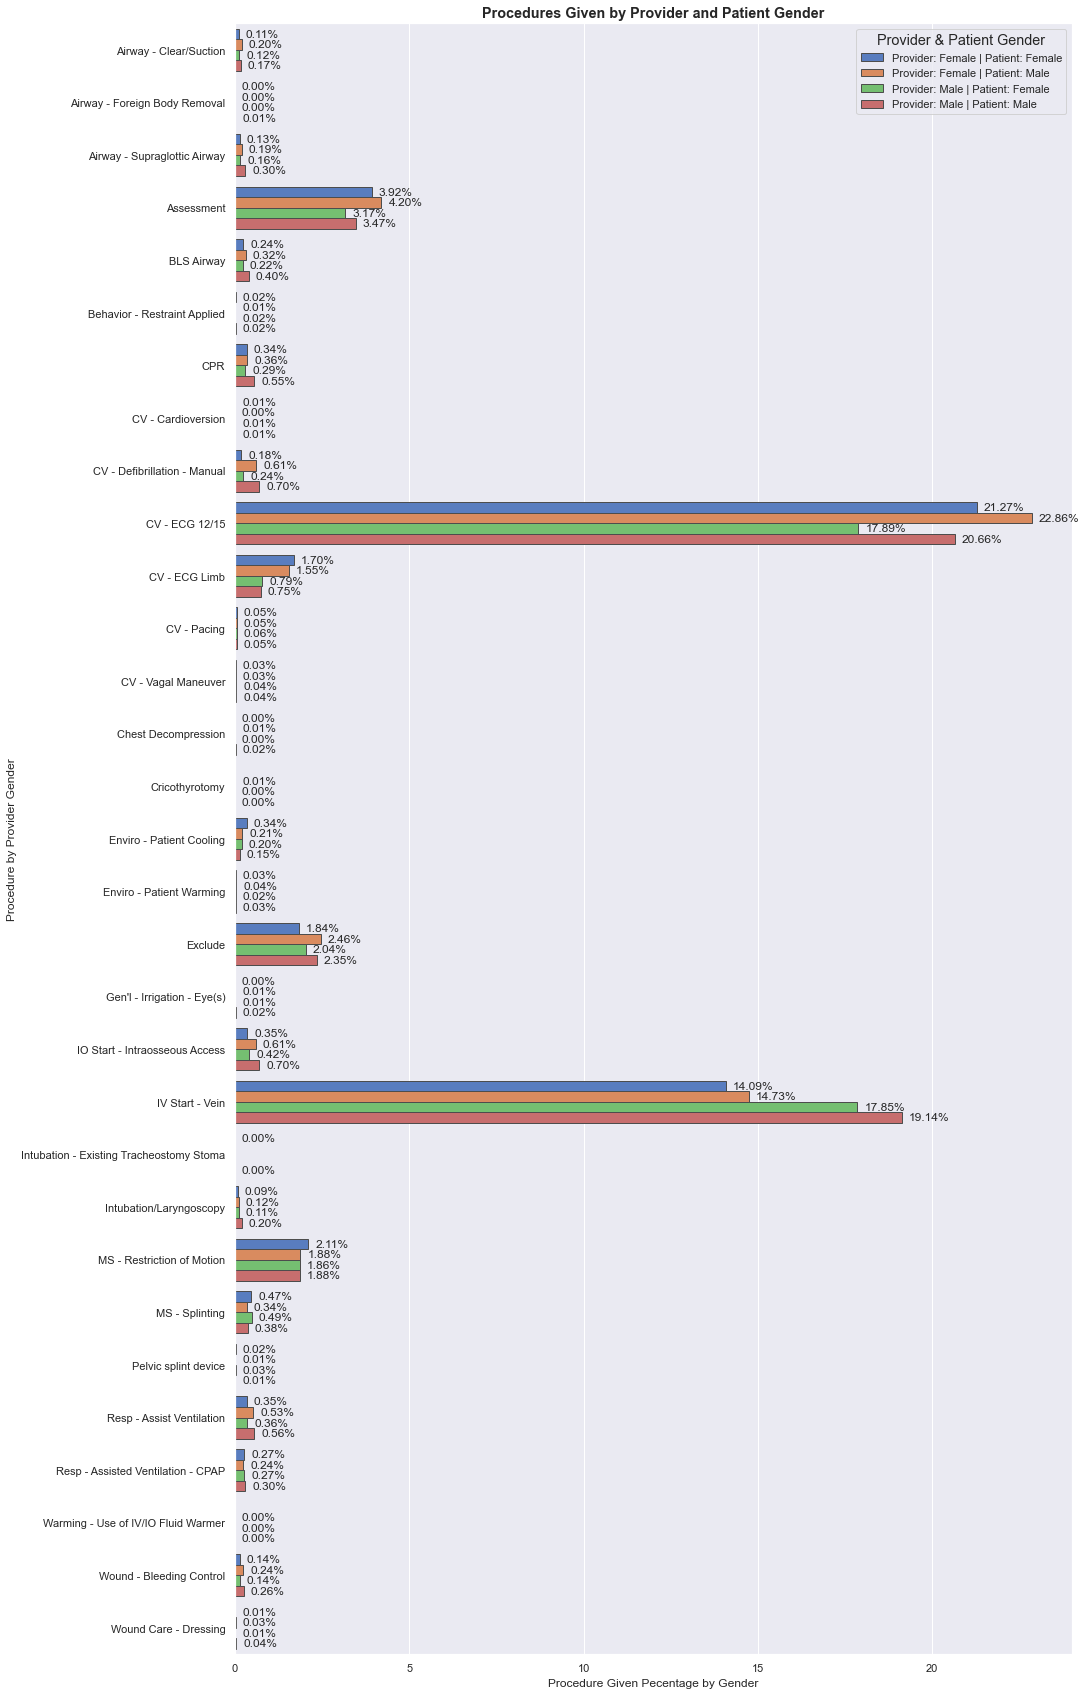

In [30]:
fig, ax = plt.subplots(figsize=(15, 30))
ax = sns.barplot(x='ProcedurePct', 
                 y='CategoryLabel', 
                 hue='ProviderPatientGender',
                 #palette='tab10',
                 #palette='colorblind',
                 palette='muted',
                 #palette='Set2',
                 edgecolor=".3",
                 data=dfProcConcat) 
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    ax.text(x = width+.2,
             y = p.get_y() + (height/2),
             s = "%.2f%%"% p.get_width(),
            va = 'center')
ax.legend(title='Provider & Patient Gender', title_fontsize='large', loc='best')
ax.set(xlabel='Procedure Given Pecentage by Gender', ylabel='Procedure by Provider Gender')
ax.set_title('Procedures Given by Provider and Patient Gender', fontsize='large', fontweight = 'bold')
plt.show()

#### **Plot Differences**

| Provider || Patient || Subtract || Provider || Patient |
|--||--||--||--||--|
|Female||Female|| Minus ||Female||Male|
|Female||Male|| Minus ||Male||Female|
|Male||Female|| Minus ||Male||Male|
|Female||Female|| Minus ||Male||Female|
|Female||Female|| Minus ||Male||Male|
|Female||Male|| Minus ||Female||Male|

Text(0.5, 1.0, 'Procedures Given by Provider and Patient Gender')

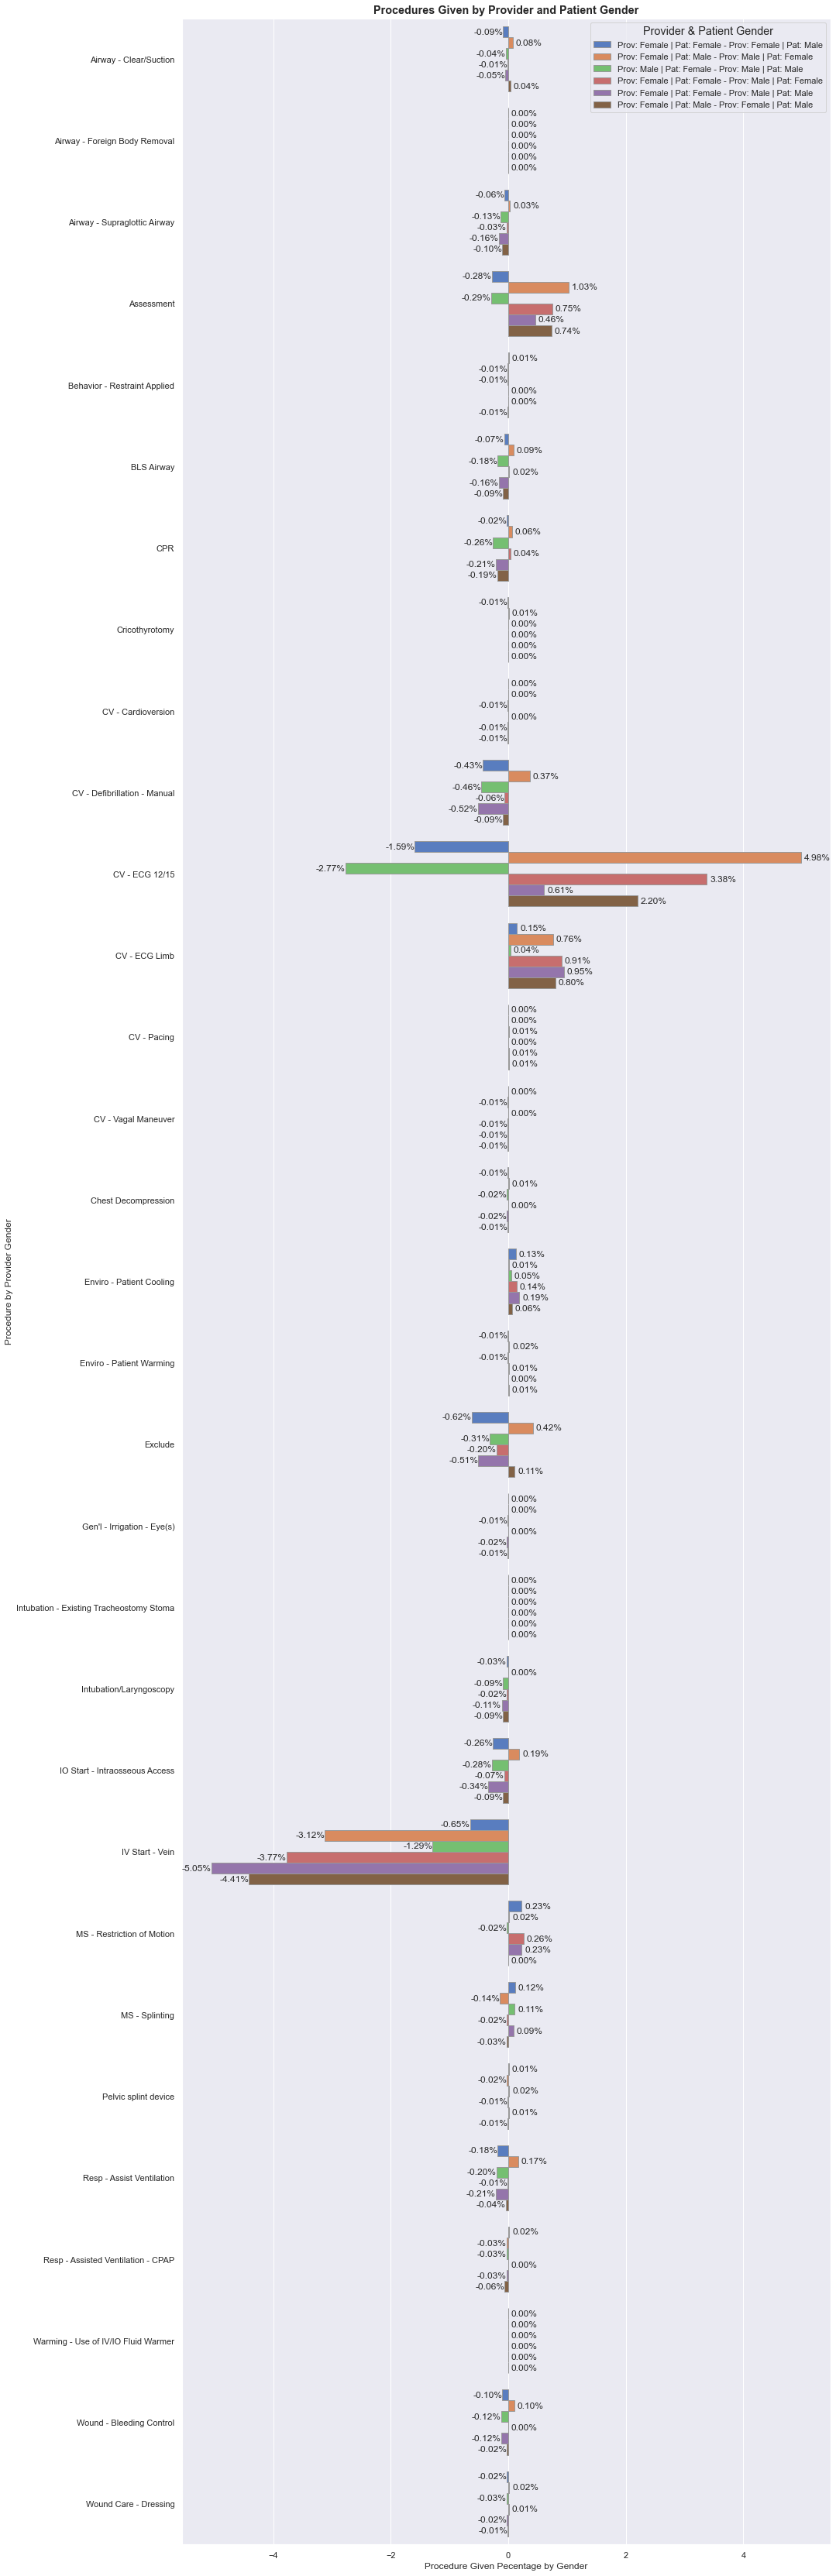

In [32]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(15, 60))
ax = sns.barplot(x='diff', 
                 y='CategoryLabel', 
                 hue='ProviderPatient',
                 #palette = ['#377eb8','#ff7f00','#4daf4a','#f781bf','#a65628','#984ea3'],
                 #palette='colorblind',
                 palette='muted',
                 #palette='tab10',
                 edgecolor=".6",
                 data=dfDistDiff) 
for p in ax.patches:
    #print('p: ', p)
    #print('get_y: ', p.get_y())
    height = p.get_height()
    width = p.get_width()
    if width >= 0:
        ax.text(x = width+.05,
                 y = p.get_y() + (height/2),
                 s = "%.2f%%"% p.get_width(),
                va = 'center')
    else:
        ax.text(x = width-.5,
                 y = p.get_y() + (height/2),
                 s = "%.2f%%"% p.get_width(),
                va = 'center')
ax.legend(title='Provider & Patient Gender', title_fontsize='large', loc='best')
ax.set(xlabel='Procedure Given Pecentage by Gender', ylabel='Procedure by Provider Gender')
ax.set_title('Procedures Given by Provider and Patient Gender', fontsize= 'large', fontweight = 'bold')

#### **Create Boxen Plot to examine distribution and identify individual outliers**

To use catplot (category plot) with boxen plots, it looks like there are several logical groupings for ideal display:
- CV - ECG and IV Start - Vein
- MS - Restriction of Motion, Assessment, and Exclude
- All others

Looking for outliers with Boxen Plots

Create dataframe for first set of boxen plots

In [33]:
filterBP1 = dfProcPat['CategoryLabel'].isin(['CV - ECG 12/15','IV Start - Vein','Assessment'])
dfProcPatBP1 = dfProcPat[filterBP1]
dfProcPatBP1.shape

(139281, 21)

In [34]:
# Create a new dataframe to define data needed for boxenplots
dfProcPatBP1 = dfProcPatBP1.groupby(['CategoryLabel','ProviderPatientGender','FRDPersonnelID']).size().reset_index(name='IDcount')
dfProcPatBP1.shape

(3740, 4)

Create dataframe for second set of boxen plots

In [40]:
filterBP2 = dfProcPat['CategoryLabel'].isin(['CV - ECG Limb','MS - Restriction of Motion','Exclude'])
dfProcPatBP2 = dfProcPat[filterBP2]
dfProcPatBP2.shape

(16963, 21)

In [41]:
# Create a new dataframe to define data needed for boxenplots
dfProcPatBP2 = dfProcPatBP2.groupby(['CategoryLabel','ProviderPatientGender','FRDPersonnelID']).size().reset_index(name='IDcount')
dfProcPatBP2.shape

(2562, 4)

Create dataframe for third set of boxen plots

In [42]:
filterBP3 = dfProcPat['CategoryLabel'].isin(['CV - Defibrillation - Manual','Enviro - Patient Cooling',
                                             'MS - Splinting','Wound - Bleeding Control'])
dfProcPatBP3 = dfProcPat[filterBP3]
dfProcPatBP3.shape

(4336, 21)

In [43]:
# Create a new dataframe to define data needed for boxenplots
dfProcPatBP3 = dfProcPatBP3.groupby(['CategoryLabel','ProviderPatientGender','FRDPersonnelID']).size().reset_index(name='IDcount')
dfProcPatBP3.shape

(1679, 4)

Create dataframe for fourth set of boxen plots

In [44]:
filterBP4 = ~dfProcPat['CategoryLabel'].isin(['CV - ECG 12/15','CV - ECG Limb','IV Start - Vein','MS - Restriction of Motion','Assessment','Exclude',
                                              'CV - Defibrillation - Manual','Enviro - Patient Cooling','MS - Splinting',
                                              'Wound - Bleeding Control'])
dfProcPatBP4 = dfProcPat[filterBP4]
dfProcPatBP4.shape

(9318, 21)

In [45]:
# Create a new dataframe to define data needed for boxenplots
dfProcPatBP4 = dfProcPatBP4.groupby(['CategoryLabel','ProviderPatientGender','FRDPersonnelID']).size().reset_index(name='IDcount')
dfProcPatBP4.shape

(5078, 4)

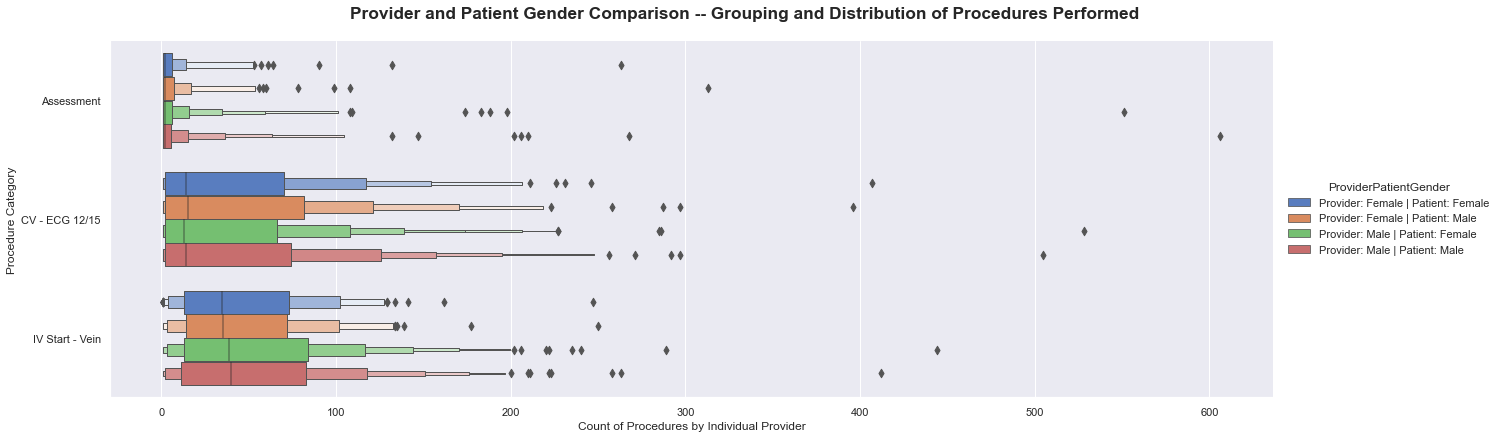

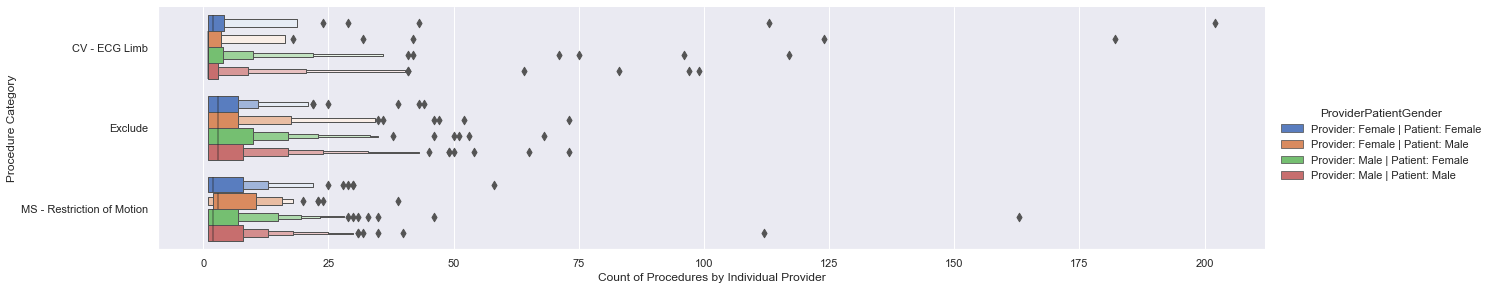

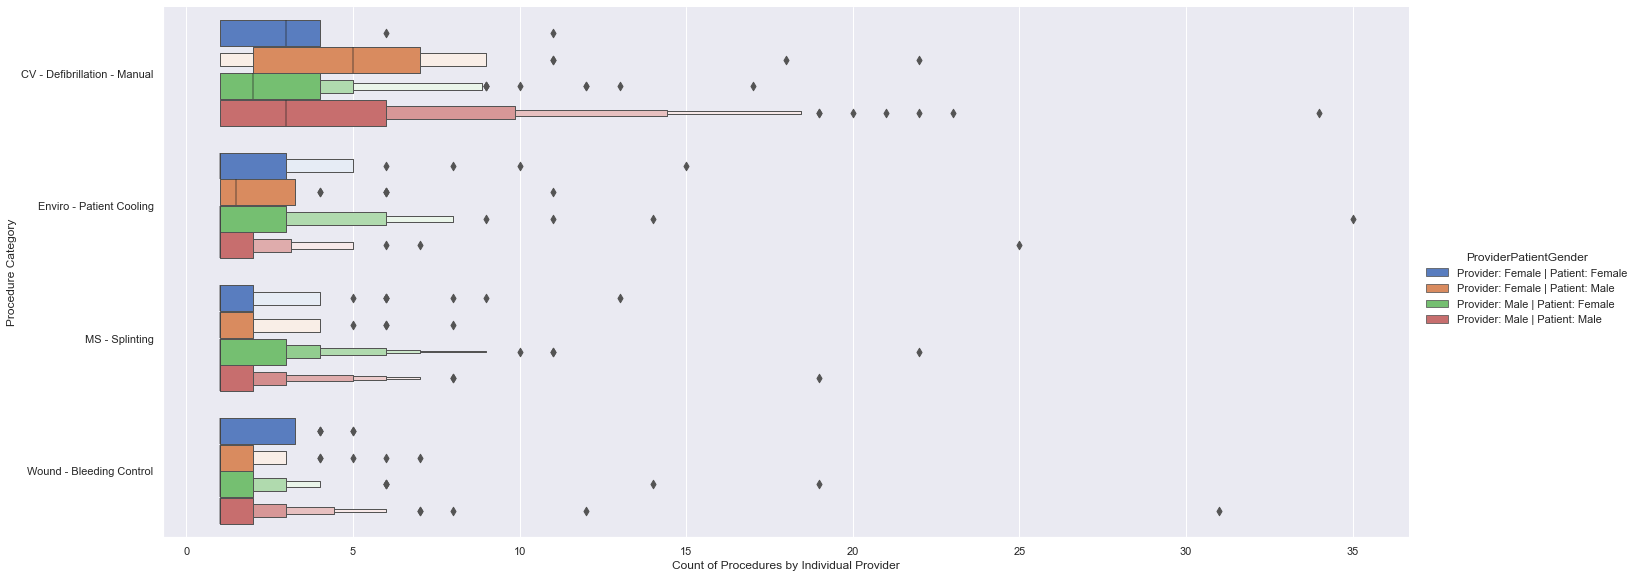

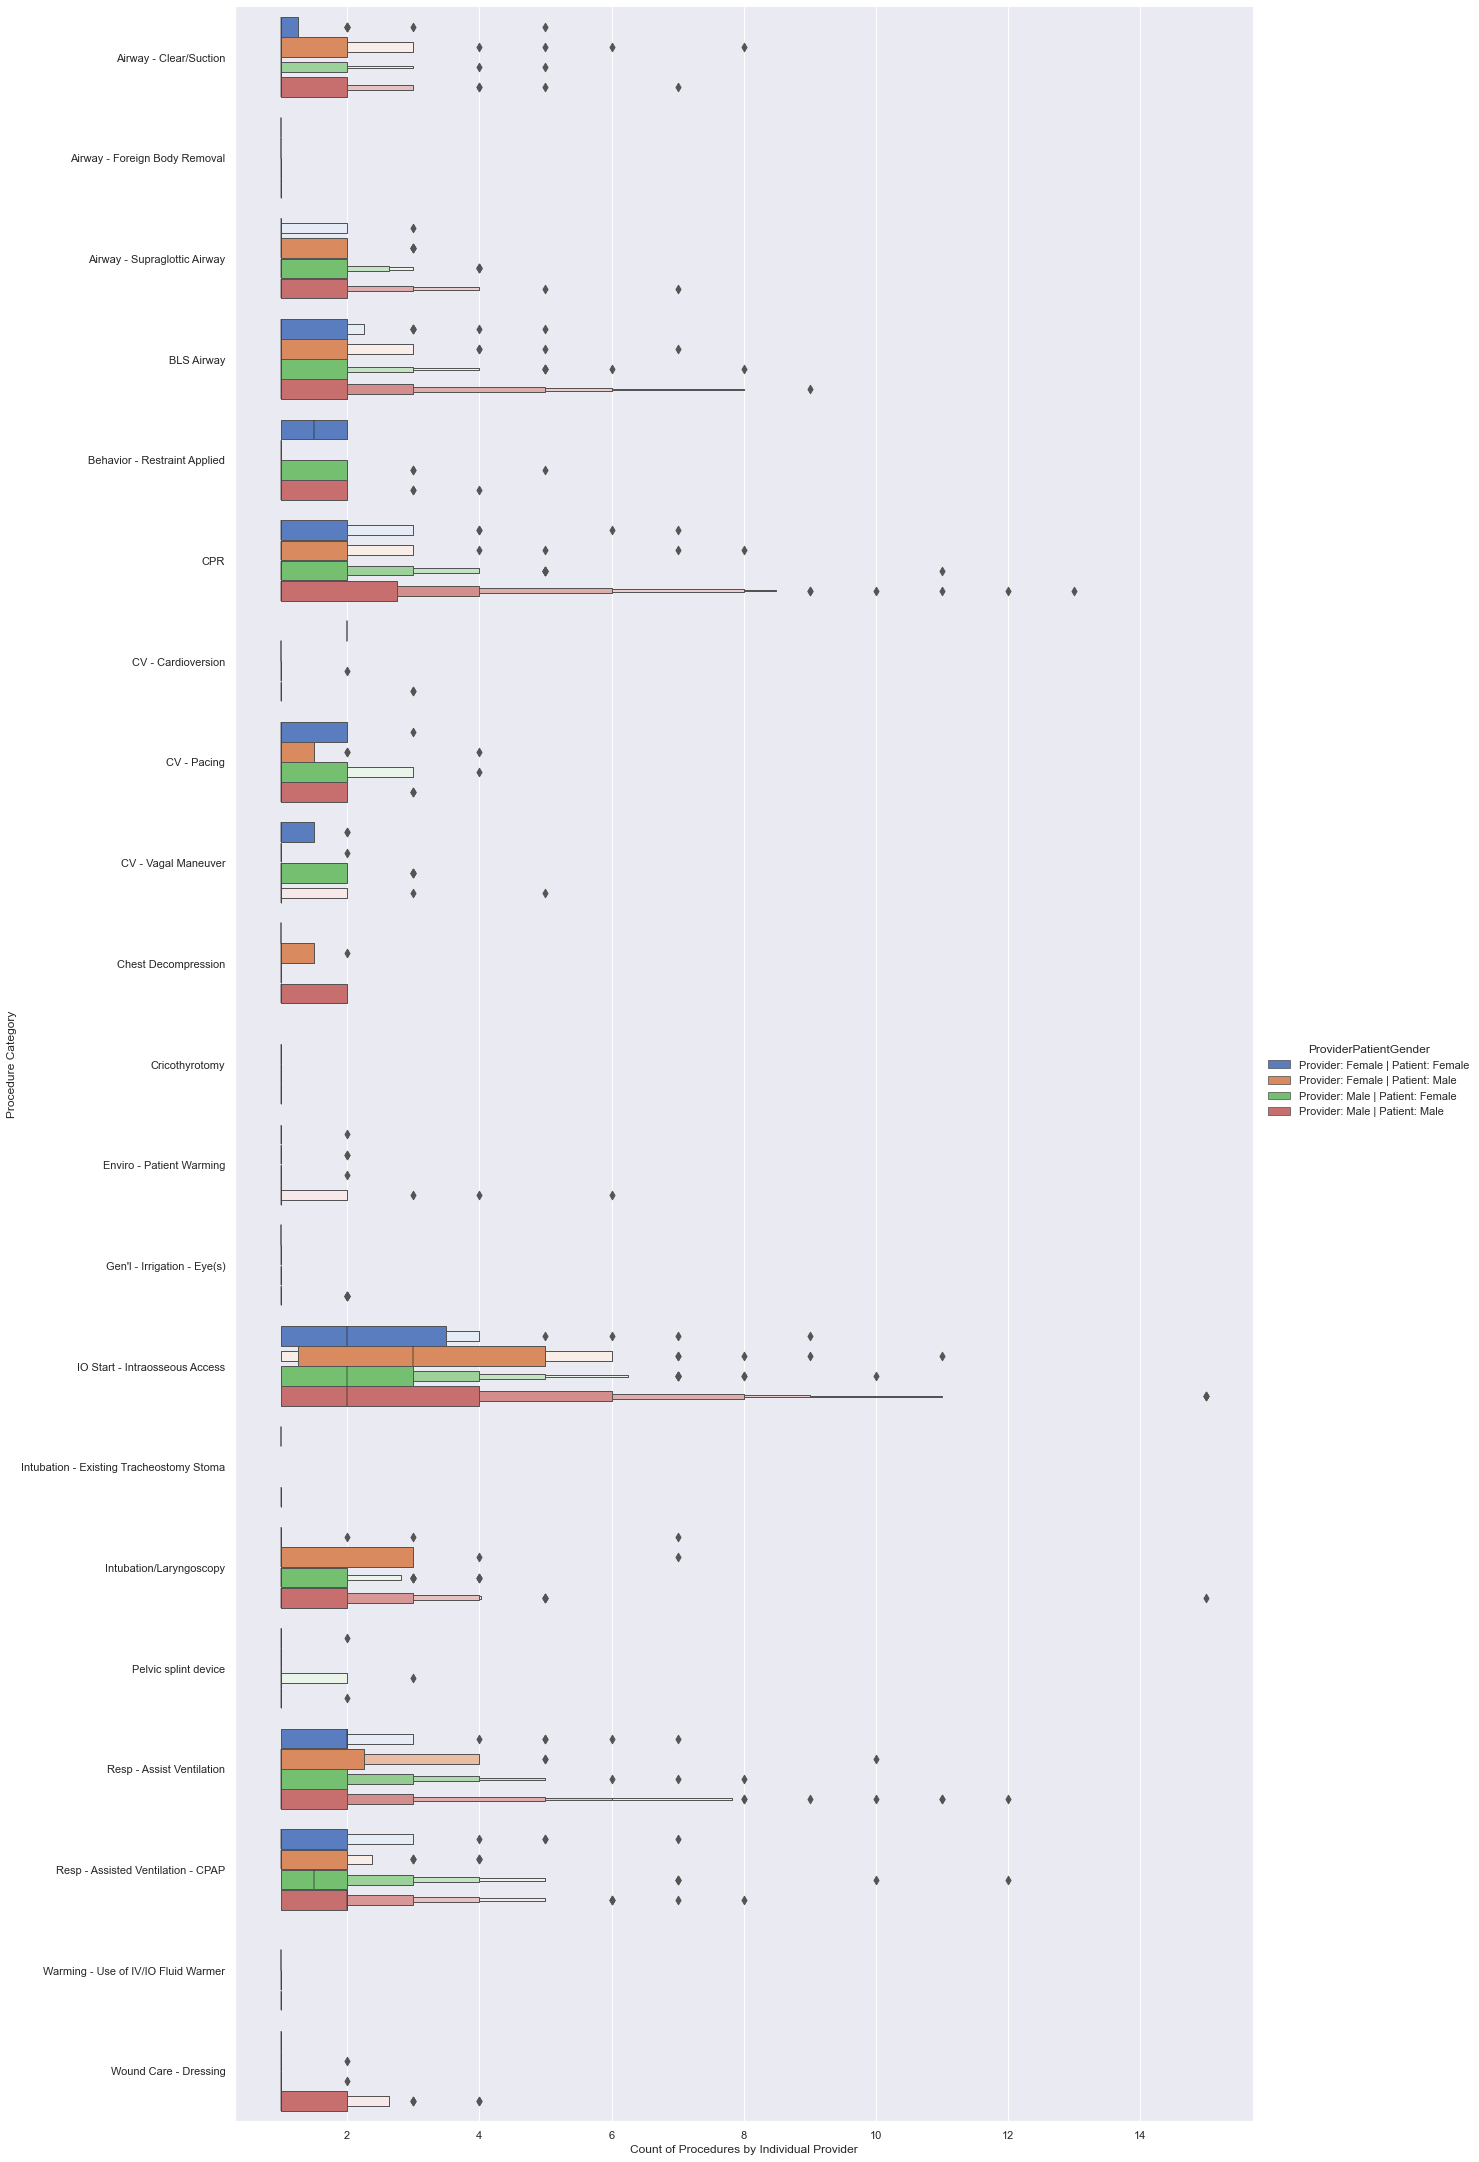

In [46]:
sns.set_theme()
g = sns.catplot(x="IDcount", 
                 y="CategoryLabel",
                 hue="ProviderPatientGender", 
                 data=dfProcPatBP1, kind="boxen",
                 palette='muted',
                 height=6, aspect=3)
g.fig.suptitle("Provider and Patient Gender Comparison -- Grouping and Distribution of Procedures Performed" ,
               fontsize='x-large', 
               fontweight = 'bold')
g.fig.subplots_adjust(top = 0.90)
g.set_axis_labels('Count of Procedures by Individual Provider','Procedure Category')

g = sns.catplot(x="IDcount", 
                y="CategoryLabel",
                hue="ProviderPatientGender", 
                data=dfProcPatBP2, kind="boxen",
                palette='muted',
                height=4, aspect=4.5)
g.set_axis_labels('Count of Procedures by Individual Provider','Procedure Category')

g = sns.catplot(x="IDcount", 
                y="CategoryLabel",
                hue="ProviderPatientGender", 
                data=dfProcPatBP3, kind="boxen",
                palette='muted',
                height=8, aspect=2.5)
g.set_axis_labels('Count of Procedures by Individual Provider','Procedure Category')

g = sns.catplot(x="IDcount", 
                y="CategoryLabel",
                hue="ProviderPatientGender", 
                data=dfProcPatBP4, kind="boxen",
                palette='muted',
                height=30, aspect=.6)
g.set_axis_labels('Count of Procedures by Individual Provider','Procedure Category')

Add some observations and insights from the output of the boxen plots

# Test Pct Only

In [50]:
dfProcPat_pct.head(3)

,CategoryLabel,ProviderPatientGender,FRDPersonnelID,Pct
0,Assessment,Provider: Female | Patient: Female,BC947748-88D1-E411-80C7-001DD8B71D38,0.882461
1,Assessment,Provider: Female | Patient: Female,3BD8C99E-9E01-E211-B5F5-78E7D18CFD3C,0.442908
2,Assessment,Provider: Female | Patient: Female,643DE51C-D5EB-4041-A96F-D93207AEEEC2,0.301983


In [51]:
#BP1_pct
filterBP1_pct = dfProcPat_pct['CategoryLabel'].isin(['CV - ECG 12/15','CV - ECG Limb','IV Start - Vein','Assessment'])
dfProcPatBP1_pct = dfProcPat_pct[filterBP1_pct]
dfProcPatBP1_pct.shape
dfProcPatBP1_pct = dfProcPatBP1_pct.groupby(['CategoryLabel','ProviderPatientGender','FRDPersonnelID','Pct']).size().reset_index(name='IDcount')
dfProcPatBP1_pct.shape
#BP2_pct
filterBP2_pct = dfProcPat_pct['CategoryLabel'].isin(['MS - Restriction of Motion','Exclude'])
dfProcPatBP2_pct = dfProcPat_pct[filterBP2_pct]
dfProcPatBP2_pct.shape
dfProcPatBP2_pct = dfProcPatBP2_pct.groupby(['CategoryLabel','ProviderPatientGender','FRDPersonnelID','Pct']).size().reset_index(name='IDcount')
dfProcPatBP2_pct.shape

#BP3_pct
filterBP3_pct = dfProcPat_pct['CategoryLabel'].isin(['CV - Defibrillation - Manual','Enviro - Patient Cooling',
                                             'MS - Splinting','Wound - Bleeding Control'])
dfProcPatBP3_pct = dfProcPat_pct[filterBP3_pct]
dfProcPatBP3_pct.shape
dfProcPatBP3_pct = dfProcPatBP3_pct.groupby(['CategoryLabel','ProviderPatientGender','FRDPersonnelID','Pct']).size().reset_index(name='IDcount')
dfProcPatBP3_pct.shape

#BP4_pct
filterBP4_pct = ~dfProcPat_pct['CategoryLabel'].isin(['CV - ECG 12/15','CV - ECG Limb','IV Start - Vein','MS - Restriction of Motion',
                                                      'Assessment','Exclude','CV - Defibrillation - Manual','Enviro - Patient Cooling',
                                                      'MS - Splinting','Wound - Bleeding Control'])
dfProcPatBP4_pct = dfProcPat_pct[filterBP4_pct]
dfProcPatBP4_pct.shape
dfProcPatBP4_pct = dfProcPatBP4_pct.groupby(['CategoryLabel','ProviderPatientGender','FRDPersonnelID','Pct']).size().reset_index(name='IDcount')
dfProcPatBP4_pct.shape

(5078, 5)

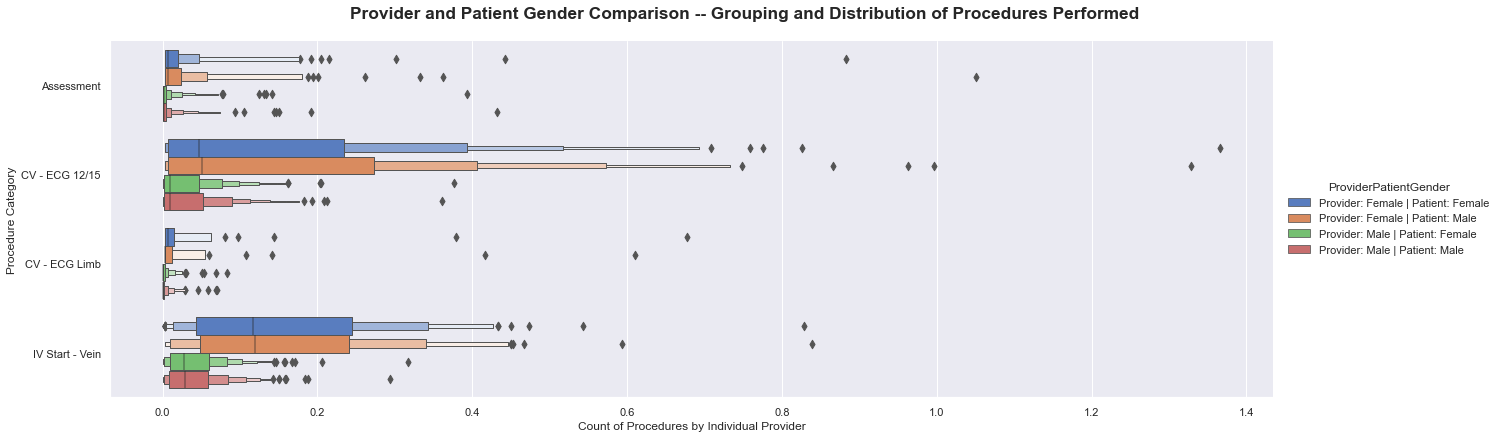

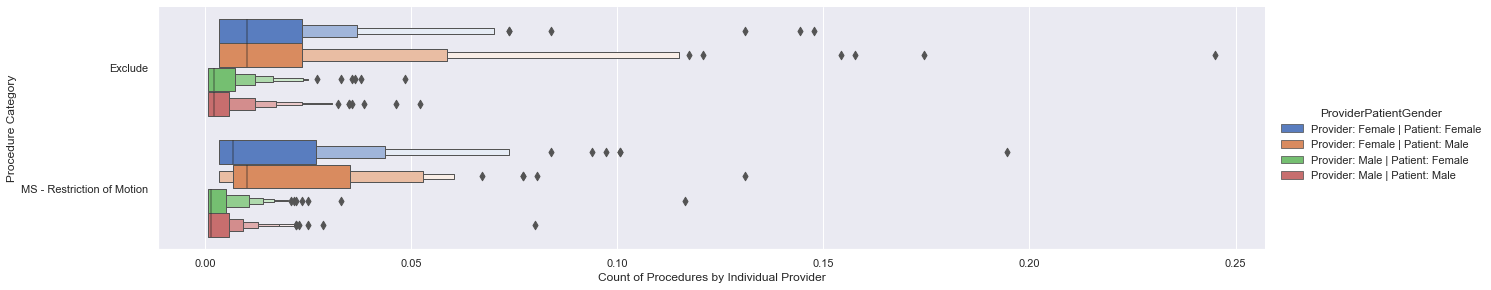

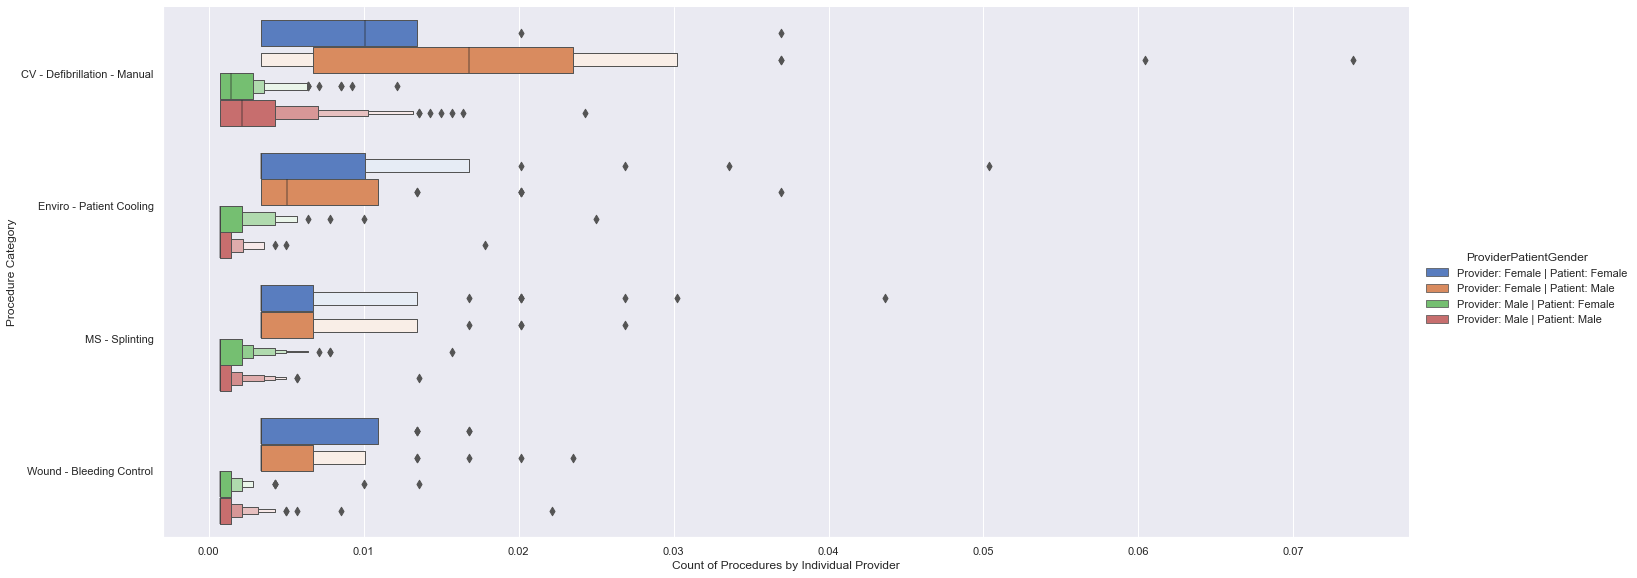

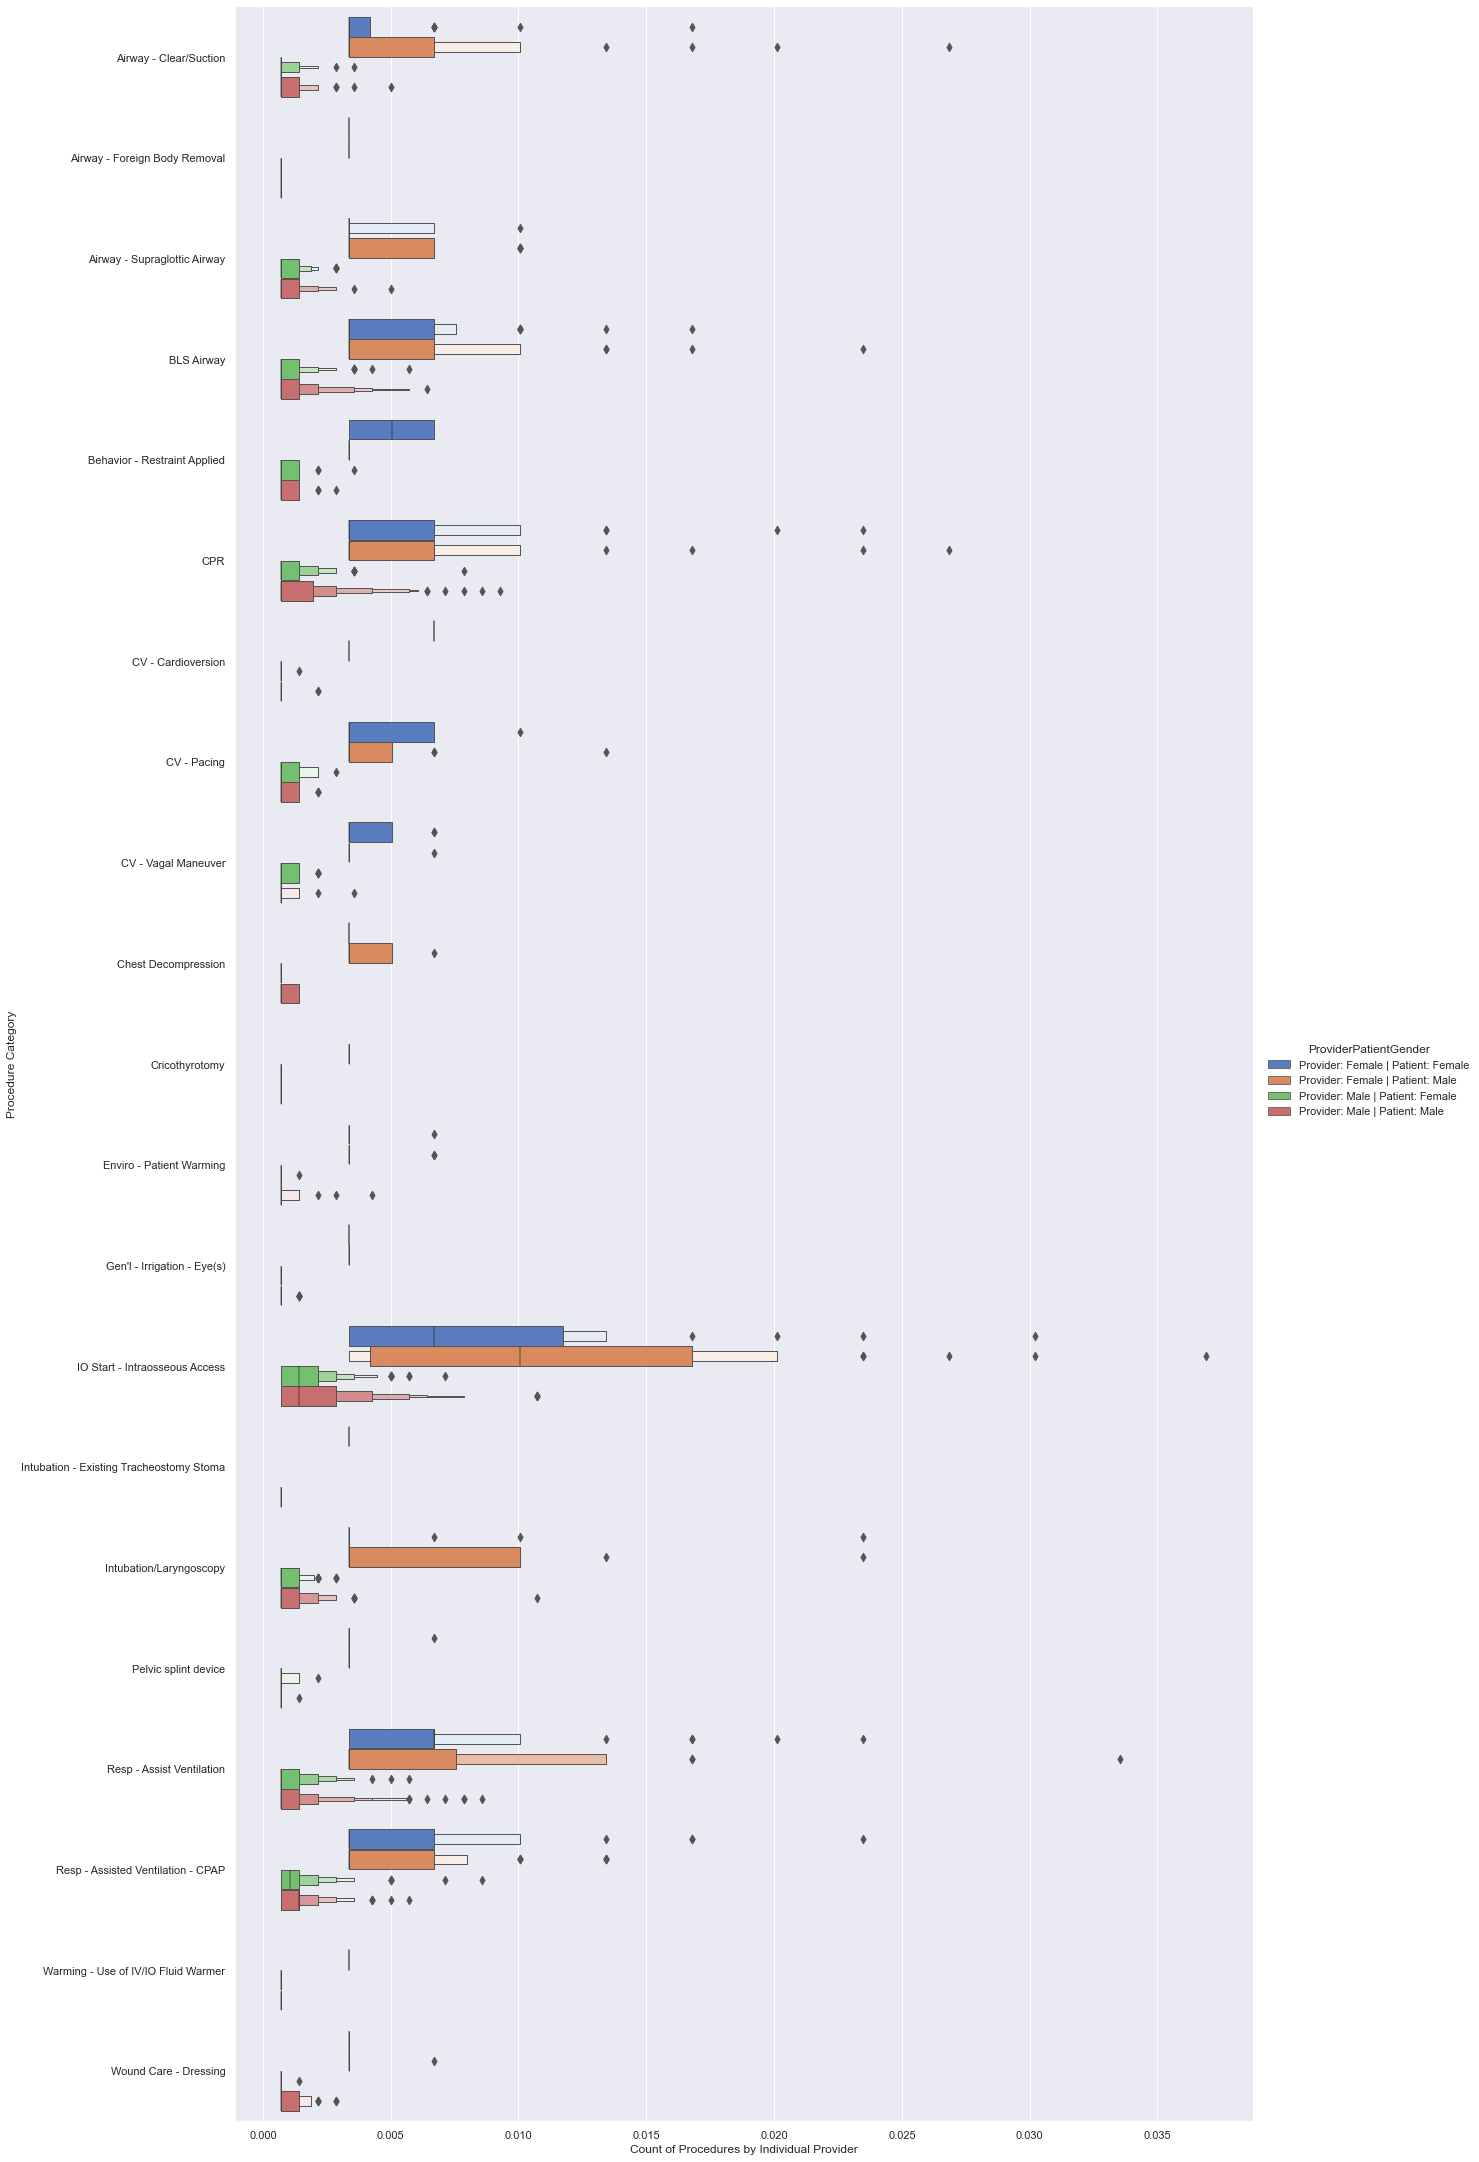

In [52]:
sns.set_theme()
g = sns.catplot(x="Pct", 
                 y="CategoryLabel",
                 hue="ProviderPatientGender", 
                 data=dfProcPatBP1_pct, kind="boxen",
                 palette='muted',
                 height=6, aspect=3)
g.fig.suptitle("Provider and Patient Gender Comparison -- Grouping and Distribution of Procedures Performed" ,
               fontsize='x-large', 
               fontweight = 'bold')
g.fig.subplots_adjust(top = 0.90)
g.set_axis_labels('Count of Procedures by Individual Provider','Procedure Category')

g = sns.catplot(x="Pct", 
                y="CategoryLabel",
                hue="ProviderPatientGender", 
                data=dfProcPatBP2_pct, kind="boxen",
                palette='muted',
                height=4, aspect=4.5)
g.set_axis_labels('Count of Procedures by Individual Provider','Procedure Category')

g = sns.catplot(x="Pct", 
                y="CategoryLabel",
                hue="ProviderPatientGender", 
                data=dfProcPatBP3_pct, kind="boxen",
                palette='muted',
                height=8, aspect=2.5)
g.set_axis_labels('Count of Procedures by Individual Provider','Procedure Category')

g = sns.catplot(x="Pct", 
                y="CategoryLabel",
                hue="ProviderPatientGender", 
                data=dfProcPatBP4_pct, kind="boxen",
                palette='muted',
                height=30, aspect=.6)
g.set_axis_labels('Count of Procedures by Individual Provider','Procedure Category')
plt.show()